# Markowitz Portfolio Optimization
The goal of this notebook is to construct a diversified portfolio using **Markowitz Portfolio Optimization**, also known as Modern Portfolio Theory (MPT).

MPT helps us construct an optimal portfolio by assigning weights to different securities (stocks) in such a way that we maximize the expected return for a given level of risk (volatility).

Additionally, we will integrate **Value at Risk (VaR)** to provide deeper insights into the risk of the portfolio under different confidence levels.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
from datetime import datetime as dt, timedelta as td
from scipy import optimize
import yfinance as yf

# Plot settings for better visualization
plt.style.use('seaborn-darkgrid')


C:\Users\14317\AppData\Local\Temp\ipykernel_30292\4144391820.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


### Stock Data Overview

We are using four stocks from different sectors to create a **diversified portfolio**:
- **Apple (AAPL)**: Technology
- **Pfizer (PFE)**: Healthcare
- **Procter & Gamble (PG)**: Consumer Goods
- **ExxonMobil (XOM)**: Energy

We fetch 2000 days of historical stock prices from Yahoo Finance and plot them for a visual overview.


[*********************100%***********************]  4 of 4 completed


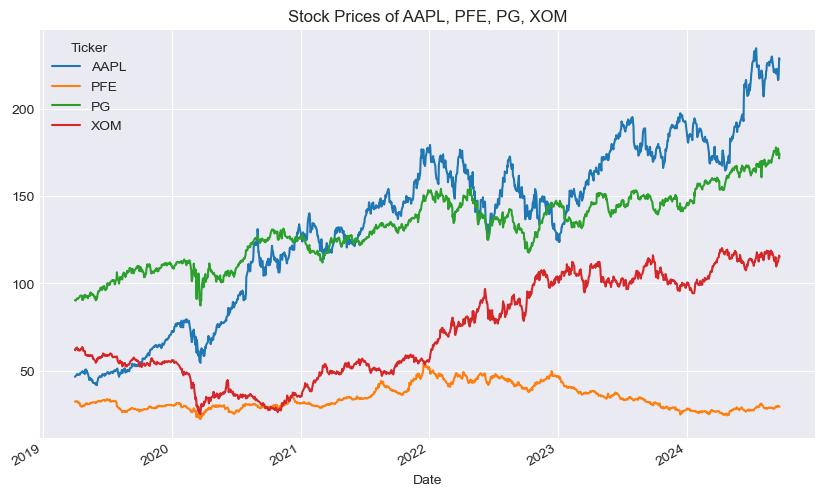

In [3]:
# Define the stocks for a diversified portfolio from different sectors
stocks = ['AAPL', 'PFE', 'PG', 'XOM']  # Apple (Technology), Pfizer (Healthcare), Procter & Gamble (Consumer Goods), ExxonMobil (Energy)

# Define the time period for historical data
end = dt.today()
start = end - td(days=2000)  # 2000 days of historical data

# Fetch the historical adjusted closing prices for the stocks from Yahoo Finance
df = yf.download(stocks, start=start, end=end)['Adj Close']

# Plot the historical prices for a visual overview
df.plot(figsize=(10,6), title="Stock Prices of AAPL, PFE, PG, XOM")
plt.show()

### Daily Log Returns
We calculate the log returns of the stocks, which are used instead of simple returns because they provide a more accurate measure of returns over time and are more stable for optimization.

Log returns are calculated as:

log return =
ln
⁡
(
Price at time t/
Price at time (t-1)
)

We then clean the data by removing any `NaN` values, which can occur due to missing data on certain days.

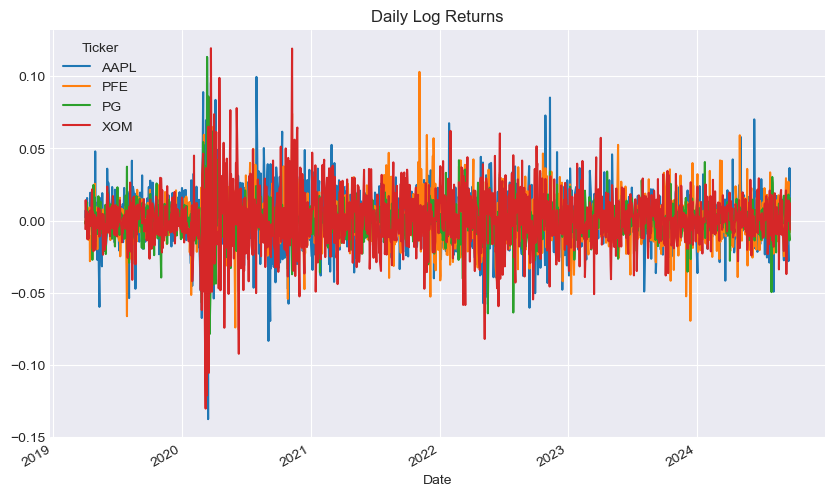

In [4]:
# Calculate daily log returns
log_returns = np.log(df / df.shift(1))

# Drop NaN values from the returns data
log_returns = log_returns.dropna()

# Plot the daily log returns for a better understanding of volatility
log_returns.plot(figsize=(10,6), title="Daily Log Returns")
plt.show()


### Monte Carlo Simulation
The Monte Carlo Simulation generates 50,000 random portfolios by assigning random weights to each stock. We calculate the annualized return, annualized volatility (risk), and the Sharpe ratio for each portfolio.

The Sharpe ratio is the measure of risk-adjusted return, calculated as:

Sharpe Ratio = 
Portfolio Return
/Portfolio Volatility


In [5]:
# Monte Carlo Simulation to generate random portfolios and evaluate performance

# Number of portfolios to simulate
num_portfolios = 50_000

# Arrays to store portfolio metrics
port_returns = []
port_volatilities = []
port_sharpe_ratios = []
port_weights = []

np.random.seed(42)  # For reproducibility

for _ in range(num_portfolios):
    # Generate random weights and normalize
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    
    # Portfolio metrics
    portfolio_return = np.sum(log_returns.mean() * weights * 252)  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))  # Annualized volatility
    sharpe_ratio = portfolio_return / portfolio_volatility  # Sharpe ratio
    
    # Store results
    port_returns.append(portfolio_return)
    port_volatilities.append(portfolio_volatility)
    port_sharpe_ratios.append(sharpe_ratio)
    port_weights.append(weights)

# Convert lists to numpy arrays for easier indexing
port_returns = np.array(port_returns)
port_volatilities = np.array(port_volatilities)
port_sharpe_ratios = np.array(port_sharpe_ratios)
port_weights = np.array(port_weights)


### Optimal Portfolio (Highest Sharpe Ratio)
From the 50,000 simulated portfolios, we select the portfolio with the maximum Sharpe ratio. This portfolio offers the best risk-adjusted return, meaning it maximizes return for the level of risk taken.

In [6]:
# Identify the portfolio with the maximum Sharpe ratio
max_sharpe_idx = port_sharpe_ratios.argmax()
max_sharpe_return = port_returns[max_sharpe_idx]
max_sharpe_volatility = port_volatilities[max_sharpe_idx]
max_sharpe_weights = port_weights[max_sharpe_idx]

# Print the portfolio with the maximum Sharpe ratio
print("Portfolio with Maximum Sharpe Ratio:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {max_sharpe_weights[i]:.2%}")
print(f"Expected Annual Return: {max_sharpe_return:.2%}")
print(f"Annual Volatility: {max_sharpe_volatility:.2%}")
print(f"Sharpe Ratio: {port_sharpe_ratios[max_sharpe_idx]:.2f}")


Portfolio with Maximum Sharpe Ratio:
AAPL: 71.03%
PFE: 0.31%
PG: 25.26%
XOM: 3.41%
Expected Annual Return: 24.07%
Annual Volatility: 25.23%
Sharpe Ratio: 0.95


### Efficient Frontier
The Efficient Frontier shows all the portfolios generated by the Monte Carlo simulation. Each point represents a portfolio, plotted with its return against its risk (volatility). The portfolio with the highest Sharpe ratio is highlighted in red.

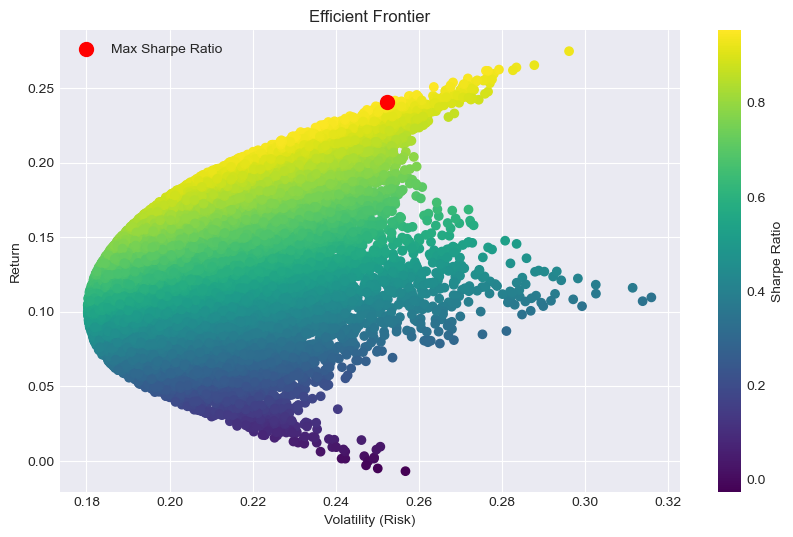

In [7]:
# Plot the Efficient Frontier

plt.figure(figsize=(10,6))
plt.scatter(port_volatilities, port_returns, c=port_sharpe_ratios, cmap='viridis')
plt.colorbar(label="Sharpe Ratio")
plt.scatter(max_sharpe_volatility, max_sharpe_return, c='red', s=100, label='Max Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()


### SciPy Optimization for Maximum Sharpe Ratio
We also use SciPy's optimization capabilities to directly calculate the portfolio weights that maximize the Sharpe ratio. This approach is more computationally efficient and provides results that are very close to those generated by the Monte Carlo simulation.



In [9]:
# SciPy Optimization to maximize Sharpe ratio

# Define helper functions for optimization
def portfolio_metrics(weights):
    portfolio_return = np.sum(log_returns.mean() * weights * 252)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def negative_sharpe(weights):
    return -portfolio_metrics(weights)[2]  # Negative Sharpe because we are minimizing

def check_sum(weights):
    return np.sum(weights) - 1  # Weights must sum to 1

# Initial guess and bounds for weights
bounds = [(0, 1) for _ in range(len(stocks))]
init_guess = [1/len(stocks)] * len(stocks)
constraints = ({'type': 'eq', 'fun': check_sum})

# Perform optimization
opt_results = optimize.minimize(negative_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal portfolio weights and metrics
opt_weights = opt_results.x
opt_return, opt_volatility, opt_sharpe = portfolio_metrics(opt_weights)

# Print the optimized portfolio
print("\nOptimized Portfolio (SciPy):")
for i, stock in enumerate(stocks):
    print(f"{stock}: {opt_weights[i]:.2%}")
print(f"Expected Annual Return: {opt_return:.2%}")
print(f"Annual Volatility: {opt_volatility:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")



Optimized Portfolio (SciPy):
AAPL: 67.82%
PFE: 0.00%
PG: 29.22%
XOM: 2.96%
Expected Annual Return: 23.56%
Annual Volatility: 24.65%
Sharpe Ratio: 0.96


### Value at Risk (VaR) Calculation

In this section, we will calculate the **Value at Risk (VaR)** for our optimized portfolio. VaR is a risk metric that quantifies the potential loss in a portfolio over a specified time period for a given confidence level.

For example, a 95% VaR of 10,000 dollars means there is a 95 percent chance that the portfolio will not lose more than $10,000 over the specified time period. 

We will implement a function to calculate the VaR based on:
-The portfolio’s historical returns.
-A specified confidence level (e.g., 95%).
-The time horizon for the VaR calculation (e.g., 1 day).

The formula for VaR is based on the normal distribution of returns and is computed as:

\[
VaR = \mu + z \cdot \sigma
\]

Where:
- \(\mu\) is the portfolio's mean return.
- \(\sigma\) is the portfolio's standard deviation (volatility).
- \(z\) is the z-score corresponding to the confidence level.

VaR Interpretation:
95% VaR means there is a 95% probability that the portfolio will not lose more than the calculated amount over the given time period.
99% VaR provides a stricter measure, indicating the maximum loss with 99% confidence.

In [13]:
def calculate_var(returns, weights, confidence_level=0.95, time_horizon=1):
    """
    Function to calculate the Value at Risk (VaR) for a portfolio given returns, weights, 
    confidence level, and time horizon.
    """
    # Calculate the portfolio's daily returns using the given weights
    portfolio_return_series = np.dot(returns, weights)
    
    # Ensure the portfolio return series is valid (no NaN or infinite values)
    portfolio_return_series = pd.Series(portfolio_return_series).dropna()
    
    # Calculate the mean and standard deviation of the portfolio's returns
    portfolio_mean = np.mean(portfolio_return_series)
    portfolio_std = np.std(portfolio_return_series)
    
    # If the standard deviation is zero, VaR cannot be calculated, return zero
    if portfolio_std == 0:
        return 0
    
    # Calculate the z-score for the given confidence level (e.g., 95%)
    from scipy.stats import norm
    z_score = norm.ppf(1 - confidence_level)
    
    # Calculate the VaR
    var = portfolio_mean + z_score * portfolio_std
    
    # Scale VaR for the time horizon (e.g., 1-day VaR or 10-day VaR)
    scaled_var = var * np.sqrt(time_horizon)
    
    return scaled_var


### VaR Calculation for the Optimized Portfolio

We calculate the **Value at Risk (VaR)** for the portfolio with the maximum Sharpe ratio at a **95% confidence level** over a 1-day time horizon. This provides an estimate of the maximum potential loss of the portfolio within that time frame.


In [14]:
# Calculate VaR for the portfolio with the maximum Sharpe ratio
max_sharpe_var = calculate_var(log_returns, max_sharpe_weights, confidence_level=0.95, time_horizon=1)

# Display the VaR for the optimized portfolio at 95% confidence level
print(f"Value at Risk (VaR) for the optimized portfolio at 95% confidence level: {max_sharpe_var:.2%}")


Value at Risk (VaR) for the optimized portfolio at 95% confidence level: -2.52%


### VaR at Different Confidence Levels

We calculate VaR at both **95%** and **99% confidence levels** to see how the portfolio's potential loss changes under stricter assumptions.

In [15]:
# Test VaR for different confidence levels
confidence_levels = [0.95, 0.99]
time_horizon = 1  # 1-day VaR

for confidence_level in confidence_levels:
    var = calculate_var(log_returns, max_sharpe_weights, confidence_level, time_horizon)
    print(f"VaR at {confidence_level*100:.0f}% confidence level: {var:.2%}")


VaR at 95% confidence level: -2.52%
VaR at 99% confidence level: -3.60%


### Optimized Portfolio Overview:
Apple (AAPL): 67.82%.

Procter & Gamble (PG): 29.22%.

ExxonMobil (XOM): 2.96%.

Pfizer (PFE): 0.00%.

The optimization algorithm assigned the highest weight to Apple (AAPL), likely due to its high return potential relative to its volatility. Procter & Gamble (PG) and ExxonMobil (XOM) also contributed to the portfolio's balance, though with much smaller weights. Pfizer (PFE) was excluded from the optimal mix, possibly due to lower returns or higher volatility compared to the other assets.

Expected Annual Return: 23.56%

Annual Volatility: 24.65%

Sharpe Ratio: 0.96

The portfolio's Sharpe ratio of 0.96 indicates a fairly good risk-adjusted return, meaning the portfolio balances risk and reward efficiently. The high allocation to technology (Apple) suggests a bias toward higher growth, but also higher risk.

### Value at Risk (VaR) Analysis:
To assess the portfolio's risk exposure, we calculated Value at Risk (VaR) at both the 95% and 99% confidence levels:

VaR at 95% Confidence Level: -2.52%

VaR at 99% Confidence Level: -3.60%

These values indicate that:

At a 95% confidence level, we can expect the portfolio to lose no more than 2.52% of its value in a day, under normal market conditions.
At a 99% confidence level, the potential maximum loss increases to 3.60%, representing a more conservative measure of risk.
The negative VaR values show that the portfolio has a downside risk, meaning that while it offers a high expected return, it also has the potential for short-term losses.

**Portfolio Composition:** The portfolio is heavily weighted toward Apple, which brings both high return potential and high volatility. While this concentration may boost returns during market upswings, it also exposes the portfolio to sector-specific risks.

**Risk Assessment:** The VaR analysis helps us quantify the potential losses under normal market conditions. A 2.52% loss at a 95% confidence level is a reasonable risk for a portfolio with an annual return of 23.56%, but investors should be prepared for larger losses in extreme market conditions (as indicated by the 99% VaR).

### Conclusion
This project demonstrates the practical application of Markowitz Portfolio Optimization and Value at Risk (VaR) in portfolio management. By combining these techniques, investors can construct a portfolio that optimizes risk-adjusted returns while quantifying potential downside risks.

However, it is important to remember that historical data and models have limitations. Future returns and risks can be affected by unforeseen events, and diversification should always be revisited as market conditions change.

In conclusion, the portfolio offers a high potential return with moderate risk, but investors should keep an eye on the technology sector's performance, given the portfolio's heavy reliance on Apple. Future improvements could include exploring other asset classes (such as bonds or international stocks) to further diversify risk.

